# Regession

The goal of this notebook is to make a time series regression for annual total days, # events, intensity, duration, severity, etc. at the global scale, regional, country and city level

#### Dependencie

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

#### Files

In [2]:
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN = 'All_data20191109_final.csv'
df = pd.read_csv(DATA_IN+FN)
FIG_OUT = '/home/cascade/projects/figures/'

# open GHS-UCDB
ghs = gpd.read_file('/home/cascade/tana-crunch-cascade/projects/UrbanHeat/data/raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp')


In [3]:
df.head()

,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,intensity,intermediate-region,region,sub-region,tmax,tot_intensity,total_days,year,start_date
0,0,Germany,1,48.138002,11.563435,2784,3.859750,44.459750,1,['1983.07.27'],[3.85975],Western Europe,Europe,Western Europe,[44.45975],3.859750,1,1983,1983.07.27
1,1,Germany,763005,48.138002,11.563435,2784,0.058337,40.658337,1,['2013.08.06'],[0.058337],Western Europe,Europe,Western Europe,[40.658337],0.058337,1,2013,2013.08.06
2,2,Germany,4,47.849642,12.102591,2833,6.893180,47.493180,1,['1983.07.27'],[6.89318],Western Europe,Europe,Western Europe,[47.49318],6.893180,1,1983,1983.07.27
3,3,Germany,22703,47.849642,12.102591,2833,1.187350,41.787350,1,['1984.07.11'],[1.18735],Western Europe,Europe,Western Europe,[41.78735],1.187350,1,1984,1984.07.11
4,4,Germany,349979,47.849642,12.102591,2833,0.793425,41.393425,1,['1998.08.11'],[0.793425],Western Europe,Europe,Western Europe,[41.393425],0.793425,1,1998,1998.08.11


In [4]:
# Add Severity
df['severity'] = df['tot_intensity'] * df['duration']


In [5]:
# Get populuations and area

df_pop = pd.DataFrame()
df_pop['ID_HDC_G0'] = ghs['ID_HDC_G0']
df_pop['AREA'] = ghs['AREA']
df_pop['P75'] = ghs['P75']
df_pop['P90'] = ghs['P90']
df_pop['P00'] = ghs['P00']
df_pop['P15'] =  ghs['P15']
df_pop['P15_wgt'] = ghs['P15'] / ghs['P15'].sum()
df_pop['AREA_wgt'] = ghs['AREA'] / ghs['AREA'].sum()
df_pop['geometry'] = ghs['geometry']

df_pop.head(1)

,ID_HDC_G0,AREA,P75,P90,P00,P15,P15_wgt,AREA_wgt,geometry
0,5782,23,76680.40387,77349.278442,75261.170776,69023.903442,0.00002,0.000035,"POLYGON ((88.1393063460871 69.36230222917577, ..."


In [ ]:
df = df.merge(df_pop, on = 'ID_HDC_G0', how = 'inner')

In [ ]:
df.head()

# What is the slope of the heat wave characteristics over time?

In [ ]:
data = df.groupby(['year'])['duration'].mean()
plt.plot(data)
plt.title('Global Duration')

In [ ]:
data = df.groupby(['year'])['tot_intensity'].mean()
plt.plot(data)
plt.title('Global Intensity')

In [ ]:
data = df.groupby(['year'])['severity'].mean()
plt.plot(data)
plt.title('Global Severity')

In [ ]:
data = df.groupby(['year'])['tot_intensity'].count()
plt.plot(data)
plt.title('Global Frequency per Year')

In [ ]:
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
plt.plot(data)
plt.title('Global Total Days per year >40.6C')

In [ ]:
#### All stacked

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (10,16), sharex=True)
fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration
data = df.groupby(['year'])['duration'].mean()
ax1.plot(data)
ax1.set_title('Mean Duration')
ax1.set_ylabel('Consecutive Days')

# Mean Intensity
data = df.groupby(['year'])['tot_intensity'].mean()
ax2.plot(data)
ax2.set_title('Mean Intensity')
ax2.set_ylabel('Degrees C > 40.6C')

# Mean Severity 
data = df.groupby(['year'])['severity'].mean()
ax3.plot(data)
ax3.set_title('Mean Severity')
ax3.set_ylabel('Duration x Intensity')

# Total Number of Events 
data = df.groupby(['year'])['tot_intensity'].count()
ax4.plot(data)
ax4.set_title('Total Frequency per Year')
ax4.set_ylabel('Number of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
ax5.plot(data)
ax5.set_title('Global Total Days per year >40.6C')
ax5.set_ylabel('Days Per Year')
ax5.set_xlabel('Year')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
# plt.savefig(FIG_OUT+'Fig1_v1')

#### Frequency by region

Text(0, 0.5, 'Frequency of heat waves per year')

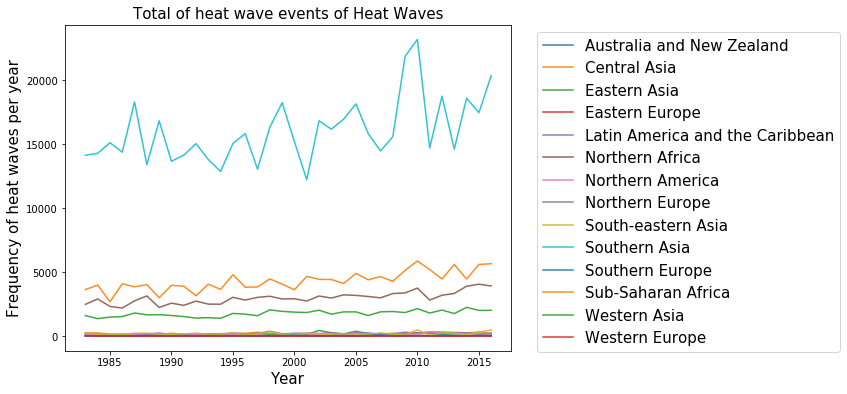

In [6]:
# plot by region 
ylabel = 'Frequency of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['ID_HDC_G0'].count()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Duration by region

Text(0, 0.5, 'Annual average duration of heat waves per year')

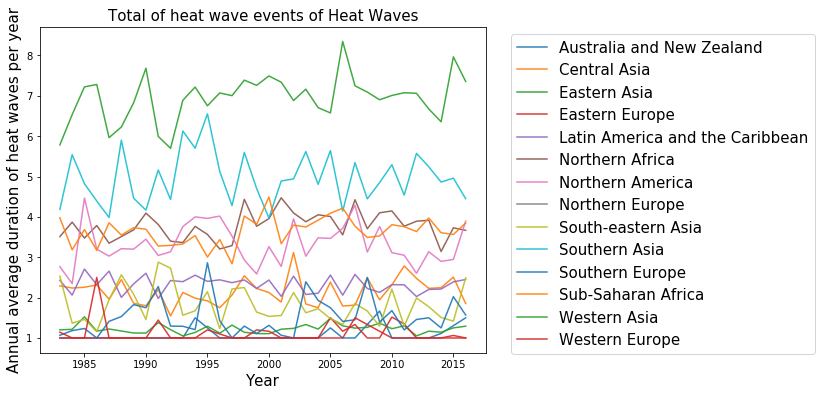

In [7]:
# plot by region 
ylabel = 'Annual average duration of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['duration'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Severity by region

Text(0, 0.5, 'Annual average severity of heat waves per year')

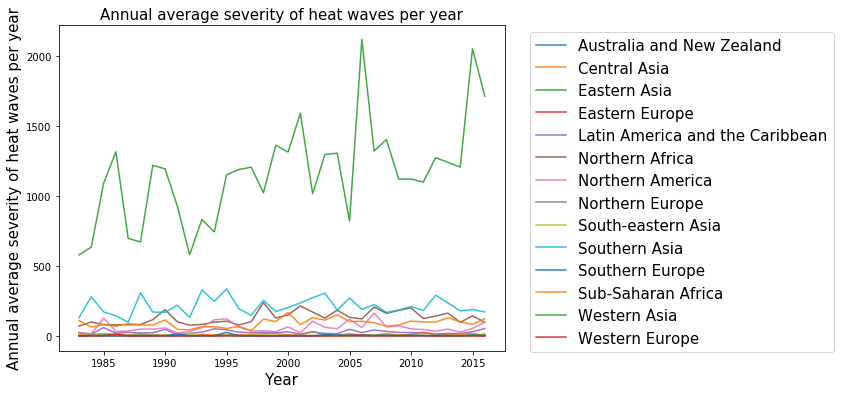

In [8]:
# plot by region 
ylabel = 'Annual average severity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['severity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average severity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Intensity by region

Text(0, 0.5, 'Annual average total intensity of heat waves per year')

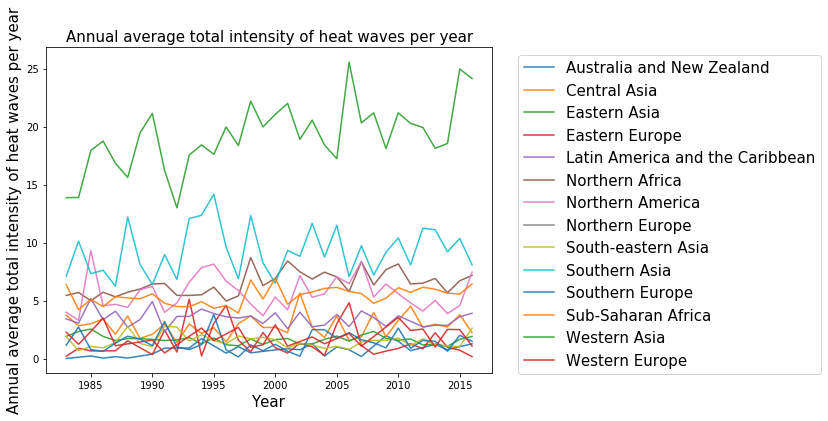

In [9]:
# plot by region 
ylabel = 'Annual average total intensity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['tot_intensity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average total intensity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Days per year by region

Text(0, 0.5, 'Avg number of days per year')

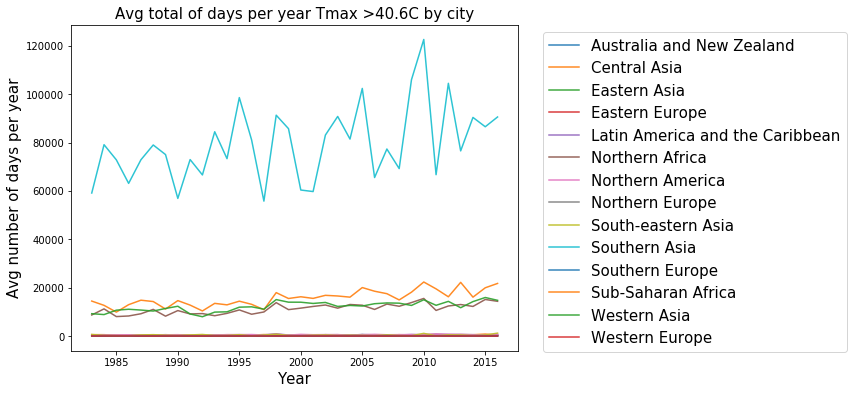

In [10]:
# plot by region 
ylabel = 'Avg number of days per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
    data = data.groupby('year')['total_days'].sum()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Avg total of days per year Tmax >40.6C by city', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)


# Plots by each event start date

In [ ]:
india = df[df['CTR_MN_NM'] == 'India']

In [ ]:
y = india['duration']
x = pd.to_datetime(india['start_date'])

In [ ]:
plt.scatter(x,y, alpha = 0.1)

# Population and Area Weighted Totals
see: https://pbpython.com/weighted-average.html

In [ ]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Duration')
plt.ylabel('Duration (days)')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Intensity')
plt.ylabel('Sum Tmax > 40.6C')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Severity')
plt.ylabel('Duration x Tot. Intensity')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Temp')
plt.ylabel('Degrees C')

In [ ]:
# Weighted count num of events by pop

data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

# get pop weights
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']
print(len(data))

## plot it 
data = data.groupby('year')['count_wgt'].sum()
plt.plot(data, **kwargs)
plt.title('Global Population-Weighted Frequency per Year')
plt.ylabel('Population-weighted Frequency of Events')


In [ ]:
# Weighted number of days num of events by pop

data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights

## plot it 
data = data.groupby('year')['days_wgt'].sum()
plt.plot(data, **kwargs)
plt.title('Global Population-Weighted Tot Number of Days per year >40.6')
plt.ylabel('Population-weighted Num of \n Days per year >40.6c')

# All plots in one

In [ ]:
#### All stacked no weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration
data = df.groupby(['year'])['duration'].mean()
ax1.plot(data, **kwargs)
ax1.set_title('Mean Duration')
ax1.set_ylabel('Consecutive Days')

# Mean Intensity
data = df.groupby(['year'])['tot_intensity'].mean()
ax2.plot(data, **kwargs)
ax2.set_title('Mean Intensity')
ax2.set_ylabel('Degrees C > 40.6C')

# Mean Temp
data = df.groupby(['year'])['avg_temp'].mean()
ax3.plot(data, **kwargs)
ax3.set_title('Mean Tempature')
ax3.set_ylabel('Degrees C > 40.6C')

# Mean Severity 
data = df.groupby(['year'])['severity'].mean()
ax4.plot(data, **kwargs)
ax4.set_title('Mean Severity')
ax4.set_ylabel('Duration x Intensity')

# Total Number of Events 
data = df.groupby(['year'])['tot_intensity'].count()
ax5.plot(data, **kwargs)
ax5.set_title('Total Frequency per Year')
ax5.set_ylabel('Number of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
ax6.plot(data, **kwargs)
ax6.set_title('Global Total Days per year >40.6C')
ax6.set_ylabel('Days Per Year')
ax6.set_xlabel('Year')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
plt.savefig(FIG_OUT+'Fig1_v1_nowgt')

In [ ]:
#### All stacked pop weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration

data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['P15']))
ax1.plot(data, **kwargs, color = 'Green')
ax1.set_title('Global Populuation-Weighted Avg. Duration')
ax1.set_ylabel('Duration (days)')

# Mean Intensity
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['P15']))
ax2.plot(data, **kwargs, color = 'Green')
ax2.set_title('Global Populuation-Weighted Avg. Intensity')
ax2.set_ylabel('Sum Tmax > 40.6C')

# Mean Temp
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['P15']))
ax3.plot(data, **kwargs, color = 'Green')
ax3.set_title('Global Populuation-Weighted Avg. Temp')
ax3.set_ylabel('Avg Temp C')

# Mean Severity 
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
ax4.plot(data, **kwargs, color = 'Green')
ax4.set_title('Global Populuation-Weighted Avg. Severity')
ax4.set_ylabel('Duration x Tot. Intensity')

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax5.plot(data, **kwargs, color = 'Green')
ax5.set_title('Global Population-Weighted Frequency per Year')
ax5.set_ylabel('Population-weighted \n Frequency of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights


data = data.groupby('year')['days_wgt'].sum()
ax6.plot(data, **kwargs, color = 'Green')
ax6.set_title('Global Population-Weighted Tot Number of Days per year >40.6')
ax6.set_ylabel('Population-weighted Num of \n Days per year >40.6c')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
plt.savefig(FIG_OUT+'Fig1_v1_popwgt')

In [ ]:
#### All stacked area weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration

data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['AREA']))
ax1.plot(data, **kwargs, color = 'Red')
ax1.set_title('Global Populuation-Weighted Avg. Duration')
ax1.set_ylabel('Duration (days)')

# Mean Intensity
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['AREA']))
ax2.plot(data, **kwargs, color = 'Red')
ax2.set_title('Global Populuation-Weighted Avg. Intensity')
ax2.set_ylabel('Sum Tmax > 40.6C')

# Mean Temp
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['AREA']))
ax3.plot(data, **kwargs, color = 'Red')
ax3.set_title('Global Populuation-Weighted Avg. Temp')
ax3.set_ylabel('Avg Temp C')

# Mean Severity 
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['AREA']))
ax4.plot(data, **kwargs, color = 'Red')
ax4.set_title('Global Populuation-Weighted Avg. Severity')
ax4.set_ylabel('Duration x Tot. Intensity')

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['AREA_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax5.plot(data, **kwargs, color = 'Red')
ax5.set_title('Global Population-Weighted Frequency per Year')
ax5.set_ylabel('Population-weighted \n Frequency of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['AREA_wgt'] # calc day weights


data = data.groupby('year')['days_wgt'].sum()
ax6.plot(data, **kwargs, color = 'Red')
ax6.set_title('Global Population-Weighted Tot Number of Days per year >40.6')
ax6.set_ylabel('Population-weighted Num of \n Days per year >40.6c')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
plt.savefig(FIG_OUT+'Fig1_v1_areawgt')

# Regessions

-- double check this

In [28]:
from numpy.polynomial.polynomial import polyfit

# make things easier for OLS
regressor = LinearRegression()  

# Geog 
geog = 'ID_HDC_G0'

# Set stat
stats = 'tot_intensity'

# Get results

labels = []
r2_list = []
coef_list = []
p_list = []
df_out = pd.DataFrame()

for label, df_c in df.groupby(geog):
    
    # Get Data
    X_year = np.array(df_c.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df_c.groupby('year')[stats].mean()).reshape((-1, 1))
    
    # Regress
    model = sm.OLS(Y_stats, X_year).fit()
    coef = model.params[0]
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    # Make lists
    labels.append(label)
    r2_list.append(r2)
    coef_list.append(coef)
    p_list.append(p)
#     print(label)
#     print(model.summary())
    
# Make data frame
df_out[geog] = labels
df_out['r2'] = r2_list
df_out['coef'] = coef_list
df_out['p_value'] = [round(elem, 4) for elem in p_list]

In [29]:
print('Reg. results for average annual', stats, 'by year 1983 - 2016')
df_out.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


Reg. results for average annual tot_intensity by year 1983 - 2016


,ID_HDC_G0,r2,coef,p_value
2220,5712,0.828785,0.068731,0.0
2228,5722,0.825369,0.057860,0.0
2202,5683,0.834907,0.050104,0.0
2214,5703,0.848435,0.049781,0.0
2245,5749,0.882712,0.048420,0.0
2205,5690,0.833525,0.047167,0.0
2193,5668,0.808470,0.044686,0.0
2217,5708,0.754960,0.044477,0.0
2173,5602,0.814799,0.044162,0.0
2196,5673,0.818911,0.044027,0.0


In [30]:
df_out_merge = df_out.merge(df, on = 'ID_HDC_G0', how = 'inner')
df_out_merge = df_out_merge.drop_duplicates('ID_HDC_G0')

In [31]:
df_out_merge.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


,ID_HDC_G0,r2,coef,p_value,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,avg_intensity,...,intensity,intermediate-region,region,sub-region,tmax,tot_intensity,total_days,year,start_date,severity
311471,5712,0.828785,0.068731,0.0,26518,Iran,2457,31.309773,48.674817,1.007353,...,[1.007353],Southern Asia,Asia,Southern Asia,[41.607353],1.007353,140,1983,1983.05.07,1.007353
312614,5722,0.825369,0.057860,0.0,28246,Iran,2778,30.649491,48.660247,0.773882,...,[0.773882],Southern Asia,Asia,Southern Asia,[41.373882],0.773882,136,1983,1983.05.05,0.773882
308155,5683,0.834907,0.050104,0.0,26003,Iran,2304,31.556492,48.186064,0.818938,...,[0.818938],Southern Asia,Asia,Southern Asia,[41.418938],0.818938,127,1983,1983.05.15,0.818938
310273,5703,0.848435,0.049781,0.0,29019,Iran,2904,30.437306,48.179071,0.291480,...,[0.29148],Southern Asia,Asia,Southern Asia,[40.89148],0.291480,126,1983,1983.05.05,0.291480
314818,5749,0.882712,0.048420,0.0,28801,Iran,2840,30.551954,49.182376,0.516421,...,[0.165408 0.867434],Southern Asia,Asia,Southern Asia,[40.765408 41.467434],1.032842,128,1983,1983.05.11,2.065684
308441,5690,0.833525,0.047167,0.0,66720,Iraq,2896,30.447697,47.994995,0.919067,...,[1.828654 0.051585 0.876963],Western Asia,Asia,Western Asia,[42.428654 40.651585 41.476963],2.757202,124,1983,1983.05.13,8.271606
306912,5668,0.808470,0.044686,0.0,66475,Iraq,2859,30.524013,47.793321,1.624064,...,[1.624064],Western Asia,Asia,Western Asia,[42.224064],1.624064,122,1983,1983.05.13,1.624064
310983,5708,0.754960,0.044477,0.0,29978,Iran,2998,30.351136,48.281395,0.692228,...,[0.459227 0.92523 ],Southern Asia,Asia,Southern Asia,[41.059227 41.52523 ],1.384457,120,1983,1983.05.14,2.768914
305269,5602,0.814799,0.044162,0.0,64106,Iraq,2321,31.526410,47.289652,1.240492,...,[1.240492],Western Asia,Asia,Western Asia,[41.840492],1.240492,127,1983,1983.05.15,1.240492
307628,5673,0.818911,0.044027,0.0,66957,Iraq,2957,30.384541,47.707023,1.510550,...,[1.51055],Western Asia,Asia,Western Asia,[42.11055],1.510550,121,1983,1983.05.13,1.510550


In [ ]:
data = df[df[geog] == 'Iraq']
year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))

In [ ]:
plt.plot(year, stats, **kwargs)

In [ ]:
# Get Data
X_year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))
    

In [ ]:
plt.plot(X_year, Y_stats)

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()

model.params